In [1]:
import bayes3d as b
import os
import jax.numpy as jnp
import jax
import bayes3d.genjax
import numpy as np
import genjax
import matplotlib
import pathlib
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7006/static/


In [3]:
intrinsics = b.Intrinsics(
    height=100,
    width=100,
    fx=200.0, fy=200.0,
    cx=50.0, cy=50.0,
    near=0.0001, far=2.0
)

b.setup_renderer(intrinsics)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


In [4]:
import trimesh
box_width = 0.02
hammer_width = 0.05
hand_length = 0.15
b1 = trimesh.creation.box(
    np.array(jnp.array([hand_length, box_width,box_width])),
    np.array(b.transform_from_pos(jnp.array([0.0, 0.0, 0.0])))
)
b2 = trimesh.creation.box(
    np.array(jnp.array([hammer_width,hammer_width, hammer_width])),
    np.array(b.transform_from_pos(jnp.array([hand_length/2 - hammer_width/2, 0.0, 0.0])))
)
b3 = trimesh.creation.box(
    np.array(jnp.array([hammer_width,hammer_width, hammer_width])),
    np.array(b.transform_from_pos(jnp.array([-hand_length/2 + hammer_width/2, 0.0, 0.0, ])))
)
m1 = trimesh.util.concatenate([b1,b2])
m2 = trimesh.util.concatenate([b1,b2,b3])
b.show_trimesh("1", m2)

b.utils.mesh.export_mesh(m1, "m1.obj")
b.utils.mesh.export_mesh(m2, "m2.obj")
table_mesh_path = b.utils.get_assets_dir() + '/sample_objs/cube.obj'

box_mesh = b.utils.make_cuboid_mesh(jnp.array([0.1, 0.1, 0.3]))
b.RENDERER.add_mesh(m1)
b.RENDERER.add_mesh(m2)
b.RENDERER.add_mesh(box_mesh)
# b.RENDERER.add_mesh_from_file(box_mesh_path, scaling_factor=1e-3)
b.RENDERER.add_mesh_from_file(table_mesh_path, scaling_factor=1e-6)

# b.clear()
# b.show_trimesh("1", b.RENDERER.meshes[FORK_IDX])
# b.show_trimesh("2", b.RENDERER.meshes[KNIFE_IDX])

# fork_mesh_path = b.utils.get_assets_dir() + '/ycb_video_models/models/030_fork/nontextured.ply'
# knife_mesh_path = b.utils.get_assets_dir() + '/ycb_video_models/models/032_knife/nontextured.ply'
# box_mesh_path = b.utils.get_assets_dir() + '/bop/ycbv/models/obj_000002.ply'

# fork_scale = knife_scale = 1.0
# box_scale = 1e-3
# table_scale = 1e-6
# mesh_paths = (fork_mesh_path, knife_mesh_path, box_mesh_path, table_mesh_path)
# scales = (fork_scale, knife_scale, box_scale, table_scale)
# for mesh_path, scale in zip(mesh_paths, scales):
#     b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=scale)

In [5]:
table_pose = b.t3d.inverse_pose(
    b.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 0.7, 0.5]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 0.0, 1.0]),
    )
)
importance_jit = jax.jit(b.model.importance)
update_jit = jax.jit(b.model.update)
enumerators = b.make_enumerator(["contact_params_2"])

In [6]:
# del importance_jit
# del update_jit

In [7]:
def make_orientation_posterior_viz(observation, is_fork, bars):
    fig = plt.figure(constrained_layout=True)
    fig.suptitle(f"is_fork: {is_fork}")
    widths = [1, 1]
    heights = [2]
    spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths,
                              height_ratios=heights)
    
    ax = fig.add_subplot(spec[0, 0])
    ax.imshow(jnp.array(b.get_depth_image(observation[...,2])))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # ax.set_title(f"Observation (params {gt_contact[0]:0.2f} {gt_contact[1]:0.2f} {gt_contact[2]:0.2f})")
    ax.set_title(f"Observed Depth")
    
    
    ax = fig.add_subplot(spec[0, 1])
    ax.bar(["knife", "fork"], bars)
    ax.set_ylim(0.0, 1.0)
    return fig

In [8]:
key = jax.random.PRNGKey(10000)

In [9]:
FORK_IDX, KNIFE_IDX, CHEESEITZ_BOX_IDX, TABLE_IDX = 0, 1, 2, 3
SHIFT_MIN = -0.3
SHIFT_SCALE = 0.6
CHEESEITZ_BOX_CONTACT_PARAMS = jnp.array([0.0, 0.2, 0.0])

contact_param_grid = jax.vmap(
    lambda shift: jnp.array([shift, 0, jnp.pi/2])
)(jnp.linspace(SHIFT_MIN, SHIFT_MIN+SHIFT_SCALE, 2000))



In [10]:
enumerators = b.make_enumerator(["contact_params_2"])
def c2f_contact_update(trace_, key, contact_param_deltas):
    contact_param_grid = contact_param_deltas + trace_[f"contact_params_2"]
    scores = enumerators[3](trace_, key, contact_param_grid)
    i = scores.argmax()
    return enumerators[0](
        trace_, key,
        contact_param_grid[i]
    )
c2f_contact_update_jit = jax.jit(c2f_contact_update)

grid_params = [
    (0.5, jnp.pi, (15,15,15)), (0.4, jnp.pi, (15,15,15)), (0.2, jnp.pi, (15,15,15)),
    (0.1, jnp.pi/3, (15,15,15)), (0.02, jnp.pi, (9,9,51)), (0.01, jnp.pi/5, (15,15,15)), (0.01, 0.0, (31,31,1)),(0.05, 0.0, (31,31,1))
]
contact_param_gridding_schedule = [
    b.utils.make_translation_grid_enumeration_3d(
        -x, -x, -ang,
        x, x, ang,
        *nums
    )
    for (x,ang,nums) in grid_params
]

In [11]:
def fork_spoon_generator(shift, is_fork):

    #indices = jnp.array([TABLE_IDX, CHEESEITZ_BOX_IDX, FORK_IDX if is_fork else KNIFE_IDX])
    indices = jax.lax.cond(is_fork,
                           lambda: jnp.array([TABLE_IDX, CHEESEITZ_BOX_IDX, FORK_IDX]),
                           lambda: jnp.array([TABLE_IDX, CHEESEITZ_BOX_IDX, KNIFE_IDX]))

    box_dims = b.RENDERER.model_box_dims[indices]
    root_poses = jnp.array([table_pose, table_pose, table_pose])
    parents = jnp.array([-1, 0, 0])
    contact_params = jnp.array([[0.0, 0.0, 0.0],
                                [*CHEESEITZ_BOX_CONTACT_PARAMS],
                                [shift, 0, jnp.pi/2]])
    faces_parents = jnp.array([0, 2, 2])
    faces_child = jnp.array([0, 3, 3])
    poses = b.scene_graph.poses_from_scene_graph(
        root_poses, box_dims, parents, contact_params, faces_parents, faces_child)
    camera_pose = jnp.eye(4)
    rendered = b.RENDERER.render(
        jnp.linalg.inv(camera_pose) @ poses , indices
    )[...,:3]
    return rendered
fork_spoon_generator_jit = jax.jit(fork_spoon_generator)

In [12]:
# del fork_spoon_generator_jit

-0.20112827 True
-16078.328


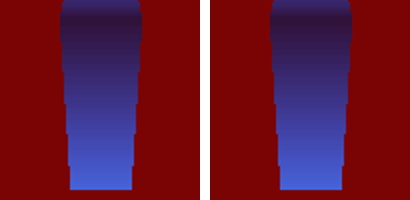

In [98]:
key = jax.random.split(key, 1)[0]
is_fork = jax.random.bernoulli(key)
key = jax.random.split(key, 1)[0]
shift = SHIFT_MIN + SHIFT_SCALE * jax.random.uniform(key)
print(shift, is_fork)
observation = fork_spoon_generator_jit(shift, is_fork)

weight, trace = importance_jit(key, genjax.choice_map({
    "parent_0": -1,
    "parent_1": 0,
    "parent_2": 0,
    "id_0": jnp.int32(3),
    "id_1": jnp.int32(CHEESEITZ_BOX_IDX),
    "id_2": (jnp.int32(FORK_IDX) if is_fork else jnp.int32(KNIFE_IDX)),
    "camera_pose": jnp.eye(4),
    "root_pose_0": table_pose,
    "face_parent_1": 2,
    "face_parent_2": 2,
    "face_child_1": 3,
    "face_child_2": 3,
    "variance": 0.001,
    "outlier_prob": 0.001,
    # "image": observation[...,:3],
    "contact_params_1": CHEESEITZ_BOX_CONTACT_PARAMS,
    # "contact_params_2": jnp.array([0.0, 0.0, 0.0])
}), (
    jnp.arange(3),
    jnp.arange(4),
    jnp.array([-jnp.ones(3)*100.0, jnp.ones(3)*100.0]),
    jnp.array([jnp.array([-0.2, -0.2, -2*jnp.pi]), jnp.array([0.2, 0.2, 2*jnp.pi])]),
    b.RENDERER.model_box_dims, 1.0, intrinsics.fx)
)
original_trace = trace
print(trace.get_score())

b.viz_trace_meshcat(trace)
b.viz_trace_rendered_observed(trace)

[-0.07448888 -0.19987457 -6.171216  ]
[-0.0795365  -0.19987457 -6.0096483 ]
[0.49989393 0.49989393]


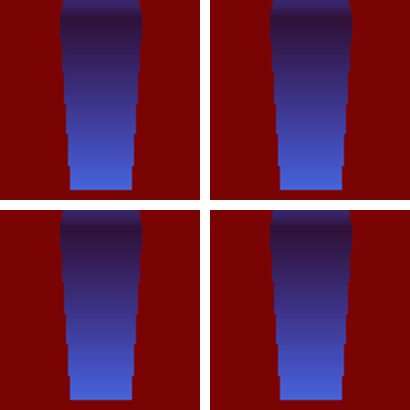

In [99]:
trace = update_jit(key, original_trace, genjax.choice_map({"id_2": KNIFE_IDX}), b.make_unknown_change_argdiffs(trace))[2]
b.viz_trace_rendered_observed(trace)
path = []
path.append(trace)
for c2f_iter in range(len(contact_param_gridding_schedule)):
    trace = c2f_contact_update_jit(trace, key, contact_param_gridding_schedule[c2f_iter])
    path.append(trace)
print(trace["contact_params_2"])
best_trace1 = path[-1]

trace = update_jit(key, original_trace, genjax.choice_map({"id_2": FORK_IDX}), b.make_unknown_change_argdiffs(trace))[2]
b.viz_trace_rendered_observed(trace)
path = []
path.append(trace)
for c2f_iter in range(len(contact_param_gridding_schedule)):
    trace = c2f_contact_update_jit(trace, key, contact_param_gridding_schedule[c2f_iter])
    path.append(trace)
print(trace["contact_params_2"])
best_trace2 = path[-1]

print(b.utils.normalize_log_scores(jnp.array([best_trace1.get_score(), best_trace2.get_score()])))
b.vstack_images([
        b.viz_trace_rendered_observed(best_trace1),
        b.viz_trace_rendered_observed(best_trace2),
])

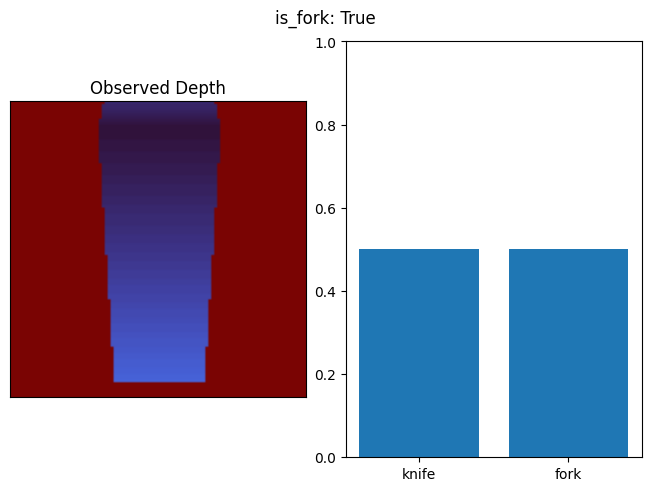

In [100]:
fig = make_orientation_posterior_viz(trace["image"], is_fork, b.utils.normalize_log_scores(jnp.array([best_trace1.get_score(), best_trace2.get_score()])))

In [62]:
is_fork

Array(True, dtype=bool)

In [148]:
b.viz_trace_meshcat(path[2])

In [78]:
idx = jnp.abs(contact_param_gridding_schedule[0] - best_trace1["contact_params_2"]).sum(-1).argmin()
print(best_trace1["contact_params_2"], contact_param_gridding_schedule[0][idx])

[0.11930968 0.         1.5707964 ] [1.1428575e-01 1.4901161e-08 1.3463972e+00]


In [ ]:
    trace = c2f_contact_update_jit(trace, key, contact_param_gridding_schedule[c2f_iter])


In [76]:
weights1 = enumerators[3](trace,key,contact_param_grid)
best_trace1 = enumerators[0](trace, key, contact_param_grid[weights1.argmax()])
b.viz_trace_meshcat(best_trace1)

In [72]:
[t["contact_params_2"] for t in path]

[Array([0., 0., 0.], dtype=float32),
 Array([ 0.11428575, -0.02857143, -2.243995  ], dtype=float32),
 Array([ 0.11428572,  0.        , -1.7951958 ], dtype=float32),
 Array([ 0.1      ,  0.1      , -0.8975979], dtype=float32),
 Array([0.03571429, 0.15      , 0.29919937], dtype=float32),
 Array([-0.01     ,  0.18     , -1.3823009], dtype=float32),
 Array([0.00857143, 0.19      , 0.62831855], dtype=float32),
 Array([0.  , 0.19, 0.  ], dtype=float32),
 Array([-0.05,  0.15,  0.  ], dtype=float32)]

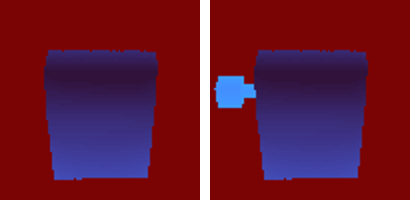

In [63]:
b.viz_trace_rendered_observed(trace)

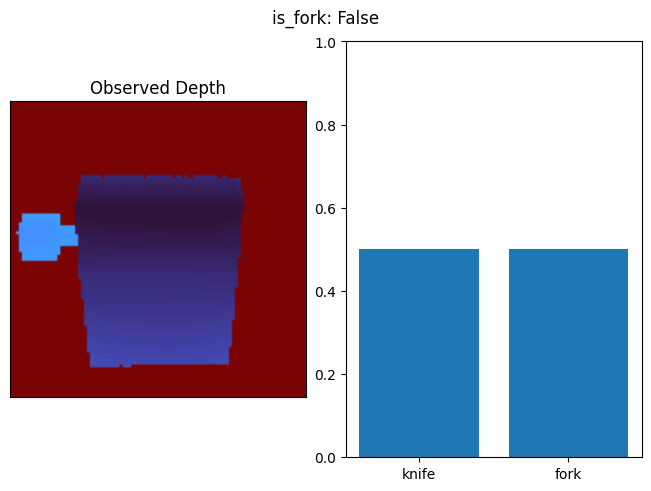

In [48]:
# pathlib.Path('knife_fork_results').mkdir(parents=True, exist_ok=True) 
experiment_iteration = 0
# for experiment_iteration in tqdm(range(10)):
# key = jax.random.split(key, 1)[0]
# is_fork = jax.random.bernoulli(key)
# key = jax.random.split(key, 1)[0]
# shift = SHIFT_MIN + SHIFT_SCALE * jax.random.uniform(key)
# print(shift, is_fork)
# observation = fork_spoon_generator_jit(0.12, is_fork)
# observation = observation[...,:3]


weights1 = enumerators[3](trace,key,contact_param_grid)
best_trace1 = enumerators[0](trace, key, contact_param_grid[weights1.argmax()])

trace = update_jit(key, trace, genjax.choice_map({"id_2": FORK_IDX}), b.make_unknown_change_argdiffs(trace))[2]
weights2 = enumerators[3](trace,key,contact_param_grid)
best_trace2 = enumerators[0](trace, key, contact_param_grid[weights2.argmax()])

fig = make_orientation_posterior_viz(observation, is_fork, b.utils.normalize_log_scores(jnp.array([weights1.max(), weights2.max()])))
# fig.savefig(f'knife_fork_results/{experiment_iteration:05d}.png')


In [ ]:
fig = make_orientation_posterior_viz(observation, is_fork, b.utils.normalize_log_scores(jnp.array([weights1.max(), weights2.max()])))
fig.savefig(f'knife_fork_results/{experiment_iteration:05d}.png')


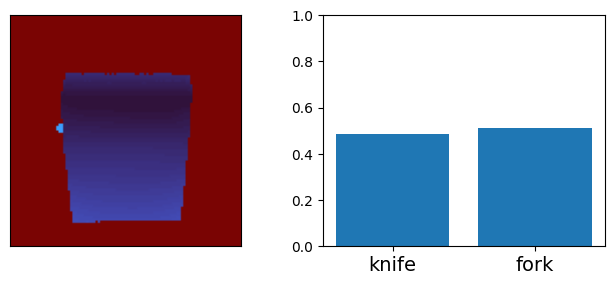

In [89]:
def make_orientation_posterior_viz(observation, is_fork, bars):
    f = plt.figure(figsize=(8,3))
    ax = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    x = np.linspace(0,4,1000)
    
    ax.imshow(jnp.array(b.get_depth_image(observation[...,2])))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # ax.set_title(f"Observation (params {gt_contact[0]:0.2f} {gt_contact[1]:0.2f} {gt_contact[2]:0.2f})")
    # ax.set_title(f"Observed Depth")
    
    
    ax2.bar(["knife", "fork"], bars)
    ax2.set_ylim(0.0, 1.0)
    ax2.set_xticks([0,1],labels=["knife", "fork"], fontsize=14)
    return f
f = make_orientation_posterior_viz(observation, is_fork, b.utils.normalize_log_scores(jnp.array([weights1.max(), weights2.max()])))


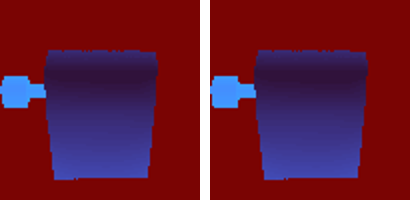

In [20]:
b.viz_trace_rendered_observed(best_trace1)

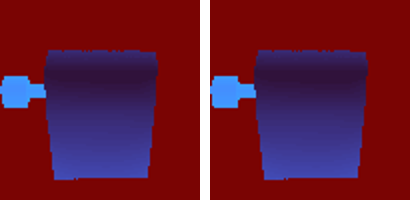

In [21]:
b.viz_trace_rendered_observed(best_trace2)